# Adding Multiple Wells

This notebook shows how a WellModel can be used to fit multiple wells with one response function. The influence of the individual wells is scaled by the distance to the observation point. 

*Developed by R.C. Caljé, (Artesia Water 2020), D.A. Brakenhoff, (Artesia Water 2019), and R.A. Collenteur, (Artesia Water 2018)*

In [1]:
import os
import numpy as np
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:09:13) [Clang 13.0.1 ]
NumPy version: 1.22.3
SciPy version: 1.9.3
Pandas version: 1.5.1
Pastas version: 0.23.0b
Matplotlib version: 3.6.2


## Load and set data

Set the coordinates of the extraction wells and calculate the distances to the observation well. 

In [2]:
# Specify coordinates observations
xo = 85850
yo = 383362

# Specify coordinates extractions
relevant_extractions = {
    "Extraction_2": (83588, 383664),
    "Extraction_3": (88439, 382339),
}

# calculate distances
distances = []
for extr, xy in relevant_extractions.items():
    xw = xy[0]
    yw = xy[1]
    distances.append(np.sqrt((xo - xw) ** 2 + (yo - yw) ** 2))

df = pd.DataFrame(
    distances,
    index=relevant_extractions.keys(),
    columns=["Distance to observation well"],
)
df

,Distance to observation well
Extraction_2,2282.070989
Extraction_3,2783.783397


Read the stresses from their csv files

In [3]:
# read oseries
oseries = pd.read_csv(
    "data_notebook_10/Observation_well.csv", index_col=0, parse_dates=[0]
).squeeze()
oseries.name = oseries.name.replace(" ", "_")
# read stresses
stresses = {}
for fname in os.listdir("data_notebook_10"):
    series = pd.read_csv(
        os.path.join("data_notebook_10", fname), index_col=0, parse_dates=[0]
    ).squeeze()
    stresses[fname.strip(".csv").replace(" ", "_")] = series

Then plot the observations, together with the diferent stresses.

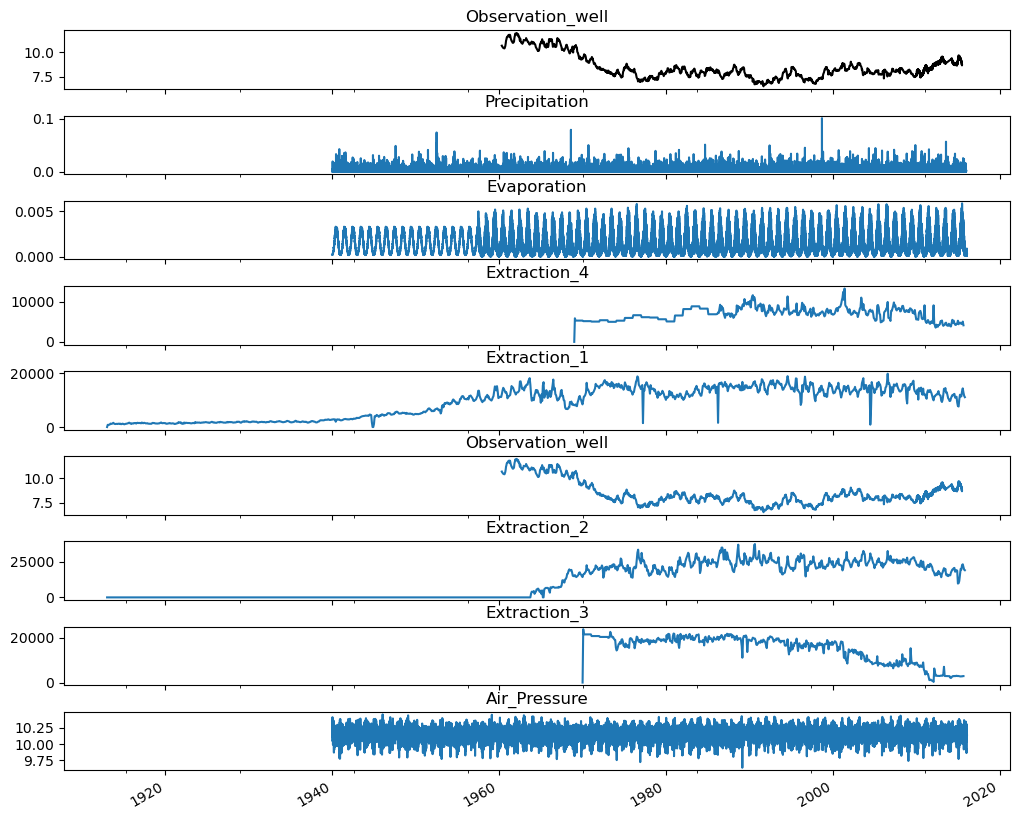

In [4]:
# plot timeseries
f1, axarr = plt.subplots(len(stresses.keys()) + 1, sharex=True, figsize=(10, 8))
oseries.plot(ax=axarr[0], color="k")
axarr[0].set_title(oseries.name)

for i, name in enumerate(stresses.keys(), start=1):
    stresses[name].plot(ax=axarr[i])
    axarr[i].set_title(name)
plt.tight_layout(pad=0)

## Create a model with a separate StressModel for each extraction

First we create a model with a separate StressModel for each groundwater extraction. First we create a model with the heads timeseries and add recharge as a stress.

In [5]:
# create model
ml = ps.Model(oseries)

Get the precipitation and evaporation timeseries and round the index to remove the hours from the timestamps.

In [6]:
prec = stresses["Precipitation"]
prec.index = prec.index.round("D")
prec.name = "prec"
evap = stresses["Evaporation"]
evap.index = evap.index.round("D")
evap.name = "evap"

Create a recharge stressmodel and add to the model.

In [7]:
rm = ps.RechargeModel(prec, evap, ps.Exponential, "Recharge")
ml.add_stressmodel(rm)

Modify the extraction timeseries.

In [8]:
name

'Air_Pressure'

In [9]:
extraction_ts = {}

for name in relevant_extractions.keys():
    # get extraction timeseries
    s = stresses[name]

    # convert index to end-of-month timeseries
    s.index = s.index.to_period("M").to_timestamp("M")

    # resample to daily values
    s_daily = ps.utils.timestep_weighted_resample_fast(s, "D").dropna()
    name = name.replace(" ", "_")
    s_daily.name = name

    # append to stresses list
    extraction_ts[name] = s_daily

Add each of the extractions as a separate StressModel.

In [10]:
for name, stress in extraction_ts.items():
    sm = ps.StressModel(stress, ps.Hantush, name, up=False, settings="well")
    ml.add_stressmodel(sm)

Solve the model. 

Note the use of `ps.LmfitSolve`. This is because of [an issue concerning optimization with small parameter values](https://github.com/pastas/pastas/issues/177) in `scipy.least_squares`. This is something that may influence models containing a WellModel (which we will be creating later) and since we want to keep the models in this Notebook as similar as possible, we're also using `ps.LmfitSolve` here.

In [11]:
ml.solve(solver=ps.LmfitSolve)

INFO: Time Series Extraction_3 was extended in the past to 1950-05-01 00:00:00 by adding 0.0 values.
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.


Fit report Observation_well              Fit Statistics
nfev    273                    EVP                93.59
nobs    2844                   R2                  0.93
noise   True                   RMSE                0.24
tmin    1960-04-28 12:00:00    AIC            -13687.07
tmax    2015-06-29 09:00:00    BIC            -13621.59
freq    D                      Obj                22.93
warmup  3650 days 00:00:00     ___                     
solver  LmfitSolve             Interp.              Yes

Parameters (11 optimized)
                    optimal    stderr     initial  vary
Recharge_A      1544.483218   ±16.17%  210.498526  True
Recharge_a       949.433435   ±19.35%   10.000000  True
Recharge_f        -1.726304   ±13.03%   -1.000000  True
Extraction_2_A    -0.000103    ±5.15%   -0.000086  True
Extraction_2_a  1265.066482   ±42.06%  100.000000  True
Extraction_2_b     0.075400   ±75.42%    1.000000  True
Extraction_3_A    -0.000045   ±12.86%   -0.000171  True
Extraction_3_a   568.

### Visualize the results
Plot the decomposition to see the individual influence of each of the wells.

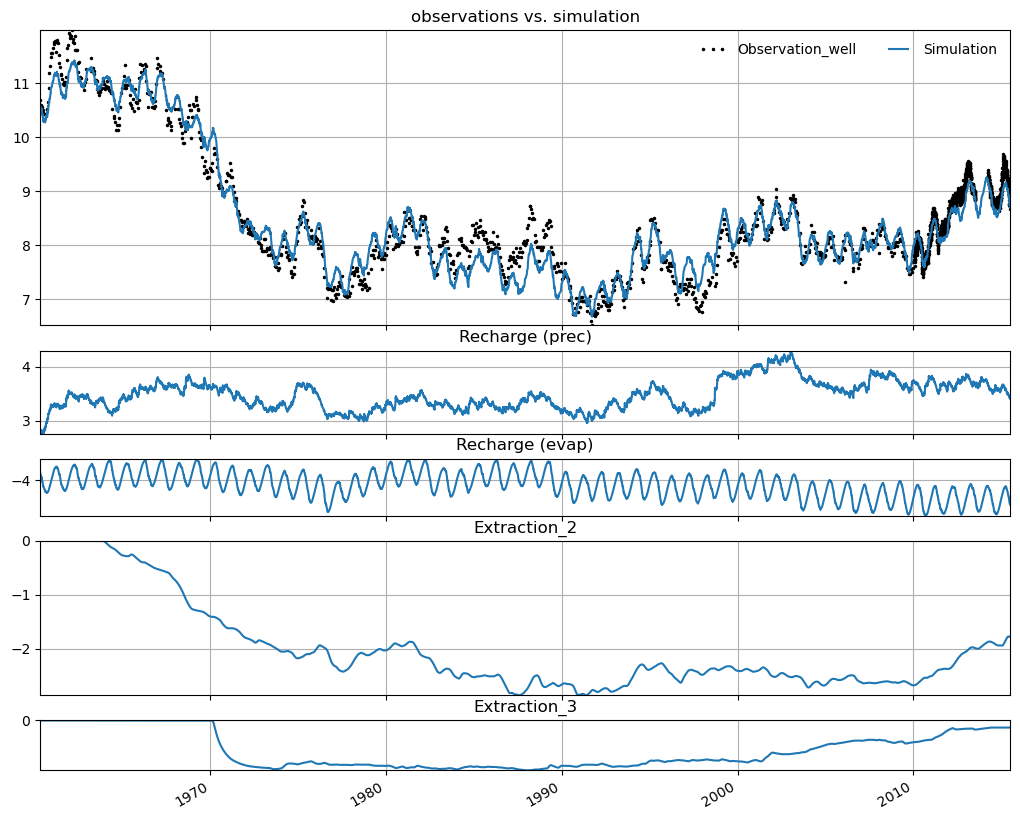

In [12]:
ml.plots.decomposition();

We can calculate the gain of each extraction (quantified as the effect on the groundwater level of a continuous extraction of ~1 Mm$^3$/yr).

In [13]:
for name in relevant_extractions.keys():
    sm = ml.stressmodels[name]
    p = ml.get_parameters(name)
    gain = sm.rfunc.gain(p) * 1e6 / 365.25
    print(f"{name}: gain = {gain:.3f} m / Mm^3/year")
    df.at[name, "gain StressModel"] = gain

Extraction_2: gain = -0.281 m / Mm^3/year
Extraction_3: gain = -0.122 m / Mm^3/year


## Create a model with a WellModel
We can reduce the number of parameters in the model by including the three extractions in a WellModel. This WellModel takes into account the distances from the three extractions to the observation well, and assumes constant geohydrological properties. All of the extractions now share the same response function, scaled by the distance between the extraction well and the observation well.

First we create a new model and add recharge.

In [14]:
ml_wm = ps.Model(oseries, oseries.name + "_wm")
rm = ps.RechargeModel(prec, evap, ps.Gamma, "Recharge")
ml_wm.add_stressmodel(rm)

We have all the information we need to create a WellModel:
- timeseries for each of the extractions, these are passed as a list of stresses
- distances from each extraction to the observation point, note that the order of these distances must correspond to the order of the stresses.

Note: the WellModel only works with a special version of the Hantush response function called `HantushWellModel`. This is because the response function must support scaling by a distance $r$. The HantushWellModel response function has been modified to support this. The Hantush response normally takes three parameters: the gain $A$, $a$ and $b$. This special version accepts 4 parameters: it interprets that fourth parameter as the distance $r$, and uses it to scale the parameters accordingly. 

Create the WellModel and add to the model.

In [15]:
w = ps.WellModel(
    extraction_ts.values(), ps.HantushWellModel, "Wells", distances, settings="well"
)
ml_wm.add_stressmodel(w)

Solve the model. 

We are once again using `ps.LmfitSolve`. The user is notified about the preference for this solver in a `WARNING` when creating the WellModel (see above). 

As we can see, the fit with the measurements (EVP) is similar to the result with the previous model, with each well included separately.

In [16]:
ml_wm.solve(solver=ps.LmfitSolve)

INFO: Time Series Extraction_3 was extended in the past to 1950-05-01 00:00:00 by adding 0.0 values.
INFO: There are observations between the simulation timesteps. Linear interpolation between simulated values is used.
INFO: No distance passed to HantushWellModel, assuming r=1.0.


Fit report Observation_well          Fit Statistics
nfev    209                    EVP            93.43
nobs    2844                   R2              0.93
noise   True                   RMSE            0.23
tmin    1960-04-28 12:00:00    AIC        -13674.64
tmax    2015-06-29 09:00:00    BIC        -13621.07
freq    D                      Obj            23.07
warmup  3650 days 00:00:00     ___                 
solver  LmfitSolve             Interp.          Yes

Parameters (9 optimized)
                 optimal   stderr     initial  vary
Recharge_A   1370.368769  ±18.57%  210.498526  True
Recharge_n      0.998879   ±3.58%    1.000000  True
Recharge_a    903.485600  ±29.40%   10.000000  True
Recharge_f     -1.999960  ±13.15%   -1.000000  True
Wells_A        -0.000245  ±53.28%   -0.000756  True
Wells_a       618.840198  ±35.90%  100.000000  True
Wells_b       -16.612586   ±3.88%  -15.674262  True
constant_d     12.057896   ±5.38%    8.557530  True
noise_alpha    57.000579   ±8.46%    1

### Visualize the results
Plot the decomposition to see the individual influence of each of the wells

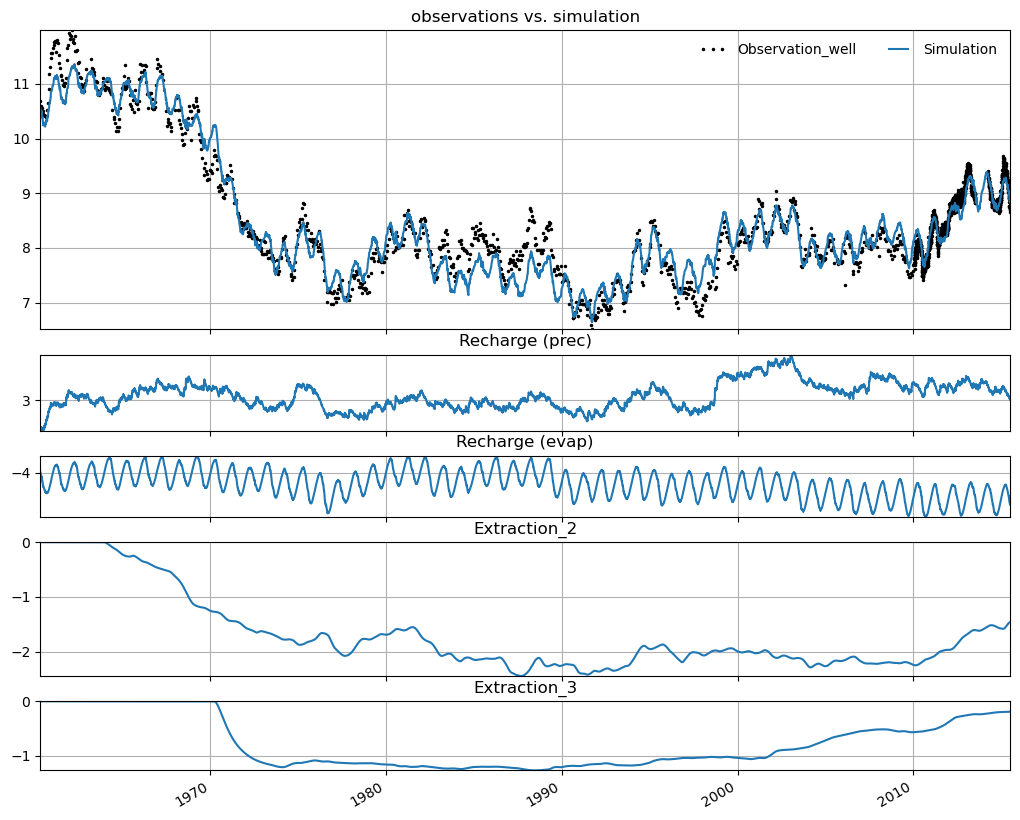

In [17]:
ml_wm.plots.decomposition();

Plot the stacked influence of each of the individual extraction wells in the results plot

INFO: No distance passed to HantushWellModel, assuming r=1.0.
INFO: No distance passed to HantushWellModel, assuming r=1.0.


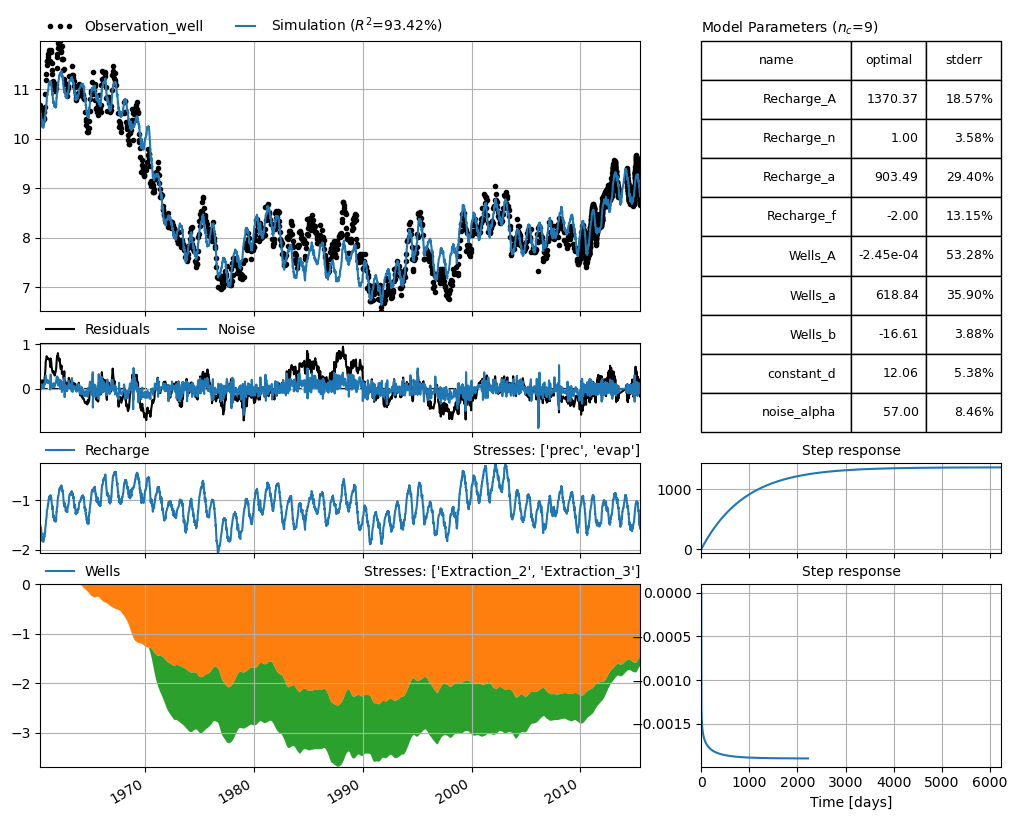

In [18]:
ml_wm.plots.stacked_results(figsize=(10, 8));

Get parameters for each well (including the distance) and calculate the gain. The WellModel reorders the stresses from closest to the observation well, to furthest from the observation well. We have take this into account during the post-processing.

The gain of extraction 3 is lower than the gain of extraction 2. This will always be the case in a WellModel when the distance from the observation well to extraction 3 is larger than the distance to extraction 2.

In [19]:
wm = ml_wm.stressmodels["Wells"]
for i, name in enumerate(relevant_extractions.keys()):
    # get parameters
    p = wm.get_parameters(model=ml_wm, istress=i)
    # calculate gain
    gain = wm.rfunc.gain(p) * 1e6 / 365.25
    name = wm.stress[i].name
    print(f"{name}: gain = {gain:.3f} m / Mm^3/year")
    df.at[name, "gain WellModel"] = gain

Extraction_2: gain = -0.236 m / Mm^3/year
Extraction_3: gain = -0.169 m / Mm^3/year


Calculate gain as function of radial distance for and plot the result, including the estimated uncertainty.

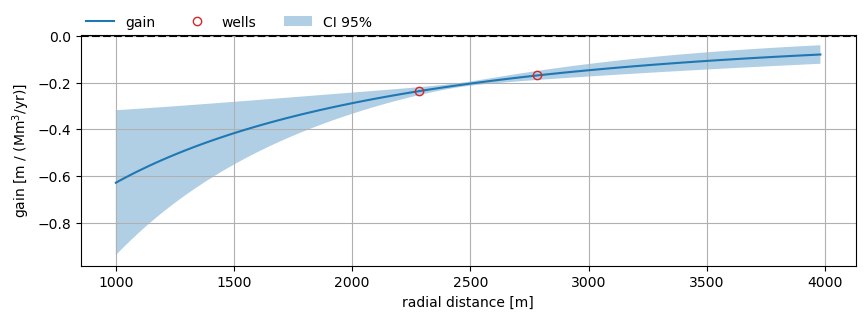

In [20]:
r = np.logspace(3, 3.6, 101)

# calculate gain and std error vs distance
params = ml_wm.get_parameters(wm.name)
gain_wells = wm.rfunc.gain(params, r=wm.distances.values) * 1e6 / 365.25
gain_vs_dist = wm.rfunc.gain(params, r=r) * 1e6 / 365.25
gain_std_vs_dist = np.sqrt(wm.variance_gain(ml_wm, r=r)) * 1e6 / 365.25

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(r, gain_vs_dist, color="C0", label="gain")
ax.plot(
    wm.distances,
    gain_wells,
    color="C3",
    marker="o",
    mfc="none",
    label="wells",
    ls="none",
)
ax.fill_between(
    r,
    gain_vs_dist - 2 * gain_std_vs_dist,
    gain_vs_dist + 2 * gain_std_vs_dist,
    alpha=0.35,
    label="CI 95%",
)
ax.axhline(0.0, linestyle="dashed", color="k")
ax.legend(loc=(0, 1), frameon=False, ncol=3)
ax.grid(visible=True)
ax.set_xlabel("radial distance [m]")
ax.set_ylabel("gain [m / (Mm$^3$/yr)]");

## Compare individual StressModels and WellModel

Compare the gains that were calculated by the individual StressModels and the WellModel.

In [21]:
df.style.format("{:.4f}")

,Distance to observation well,gain StressModel,gain WellModel
Extraction_2,2282.0710,-0.2814,-0.2365
Extraction_3,2783.7834,-0.1220,-0.1692


Visually compare the two models, including the calculated contribution of the wells:

INFO: No distance passed to HantushWellModel, assuming r=1.0.
INFO: No distance passed to HantushWellModel, assuming r=1.0.


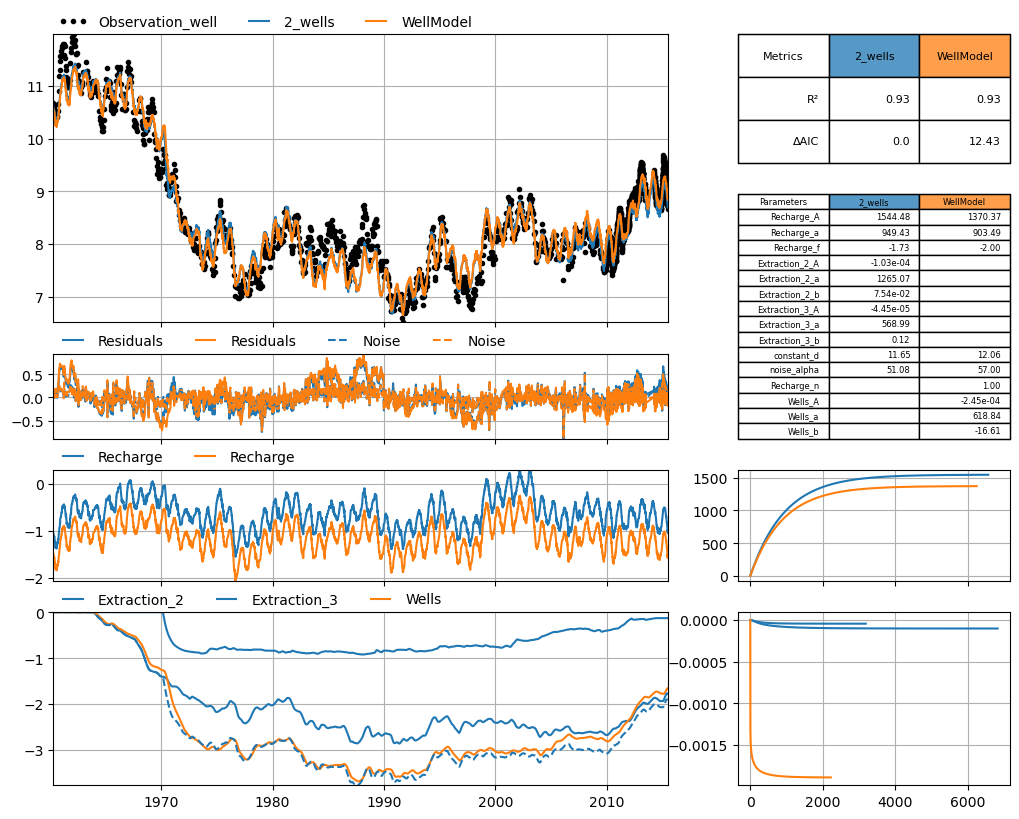

In [22]:
# give models descriptive name
ml.name = "2_wells"
ml_wm.name = "WellModel"

# plot well stresses together on same plot:
smdict = {0: ["Recharge"], 1: ["Extraction_2", "Extraction_3", "Wells"]}

# comparison plot
mc = ps.CompareModels([ml, ml_wm])
mosaic = mc.get_default_mosaic(n_stressmodels=2)
mc.initialize_adjust_height_figure(mosaic=mosaic, smdict=smdict)
mc.plot(smdict=smdict)

sumwells = ml.get_contribution("Extraction_2") + ml.get_contribution("Extraction_3")
mc.axes["con1"].plot(sumwells.index, sumwells, ls="dashed", color="C0");